In [1]:
# import settings and functions
%run ./../../dataset_creation_imports.ipynb

Imports finished! :D
Importing dataset creation functions...


## What mesh?

Copy your choice to the next cell

for SquareTop:
```
analytical_solution_tag = "-ana_square_top"
generate_config = generateConfig_squareTop
generate_mesh = generateMesh_squareTop
```

for SquareSinCos:
```
analytical_solution_tag = "-ana_square_sincos"
generate_config = generateConfig_squareSinCos
generate_mesh = generateMesh_squareSinCos
```

In [2]:
# Change according to instruction above
analytical_solution_tag = "-ana_square_sincos"
generate_config = generateConfig_squareSinCos
generate_mesh = generateMesh_squareSinCos

# analytical_solution_tag = "-ana_L_shape"
# generate_config = generateConfig_Lshape
# generate_mesh = generateMesh_Lshape

# analytical_solution_tag = "-ana_mexi_hat"
# generate_config = generateConfig_squareMexiHat
# generate_mesh = generateMesh_squareMexiHat

# analytical_solution_tag = "-ana_square_top"
# generate_config = generateConfig_squareTop
# generate_mesh = generateMesh_squareTop

In [3]:
exe = data_driven_diffusion_snes
# exe = hdiv_data_driven_diffusion_snes

In [4]:
how_many = 41
#
params.conductivity = 1.0 # linear conductivity
params.element_size = 0.05 # element size in the regular mesh
params.order = 2 # approximation order for displacements
# Pre-processing parameters
params.mesh_file = "square_top"
params.length_x = 1
params.length_y = 1

params.nproc = 1 # number of processors

In [5]:
# start display for showing results
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()

[SET_ATTR_FLUX_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 
[SET_ATTR_PRESSURE_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 
[SET_ATTR_SOURCE_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 
Read "square_top.h5m"
Wrote "square_top.vtk"


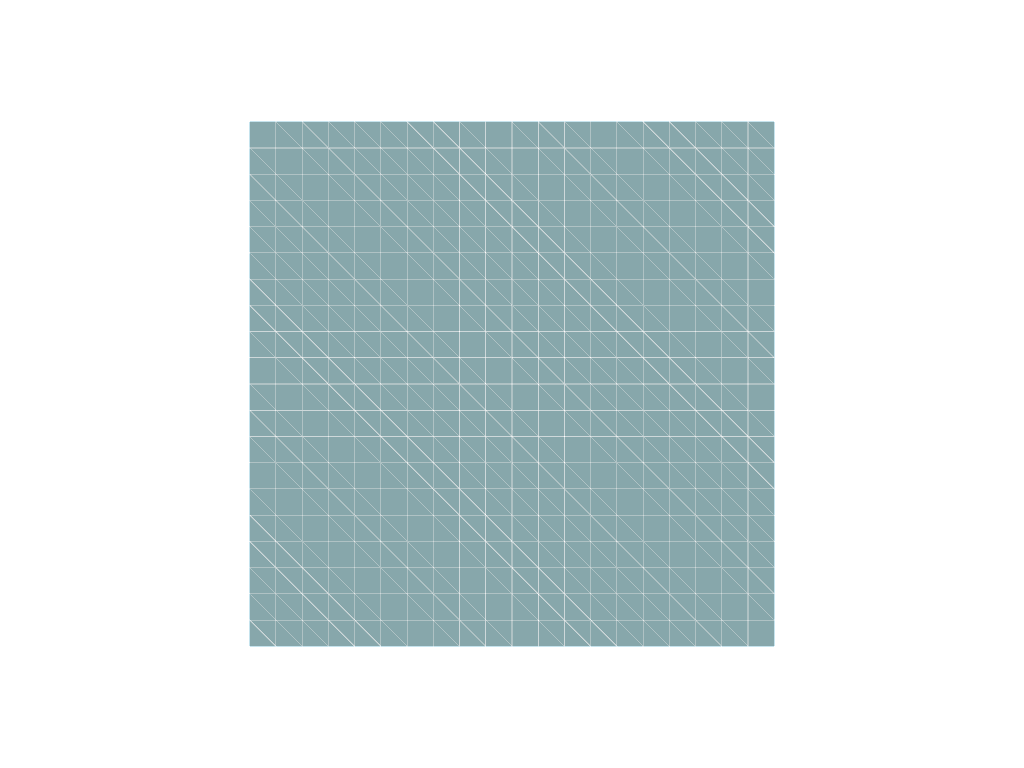

In [6]:
# Testing mesh generation

params.show_mesh = True
generate_config(params)
generate_mesh(params)

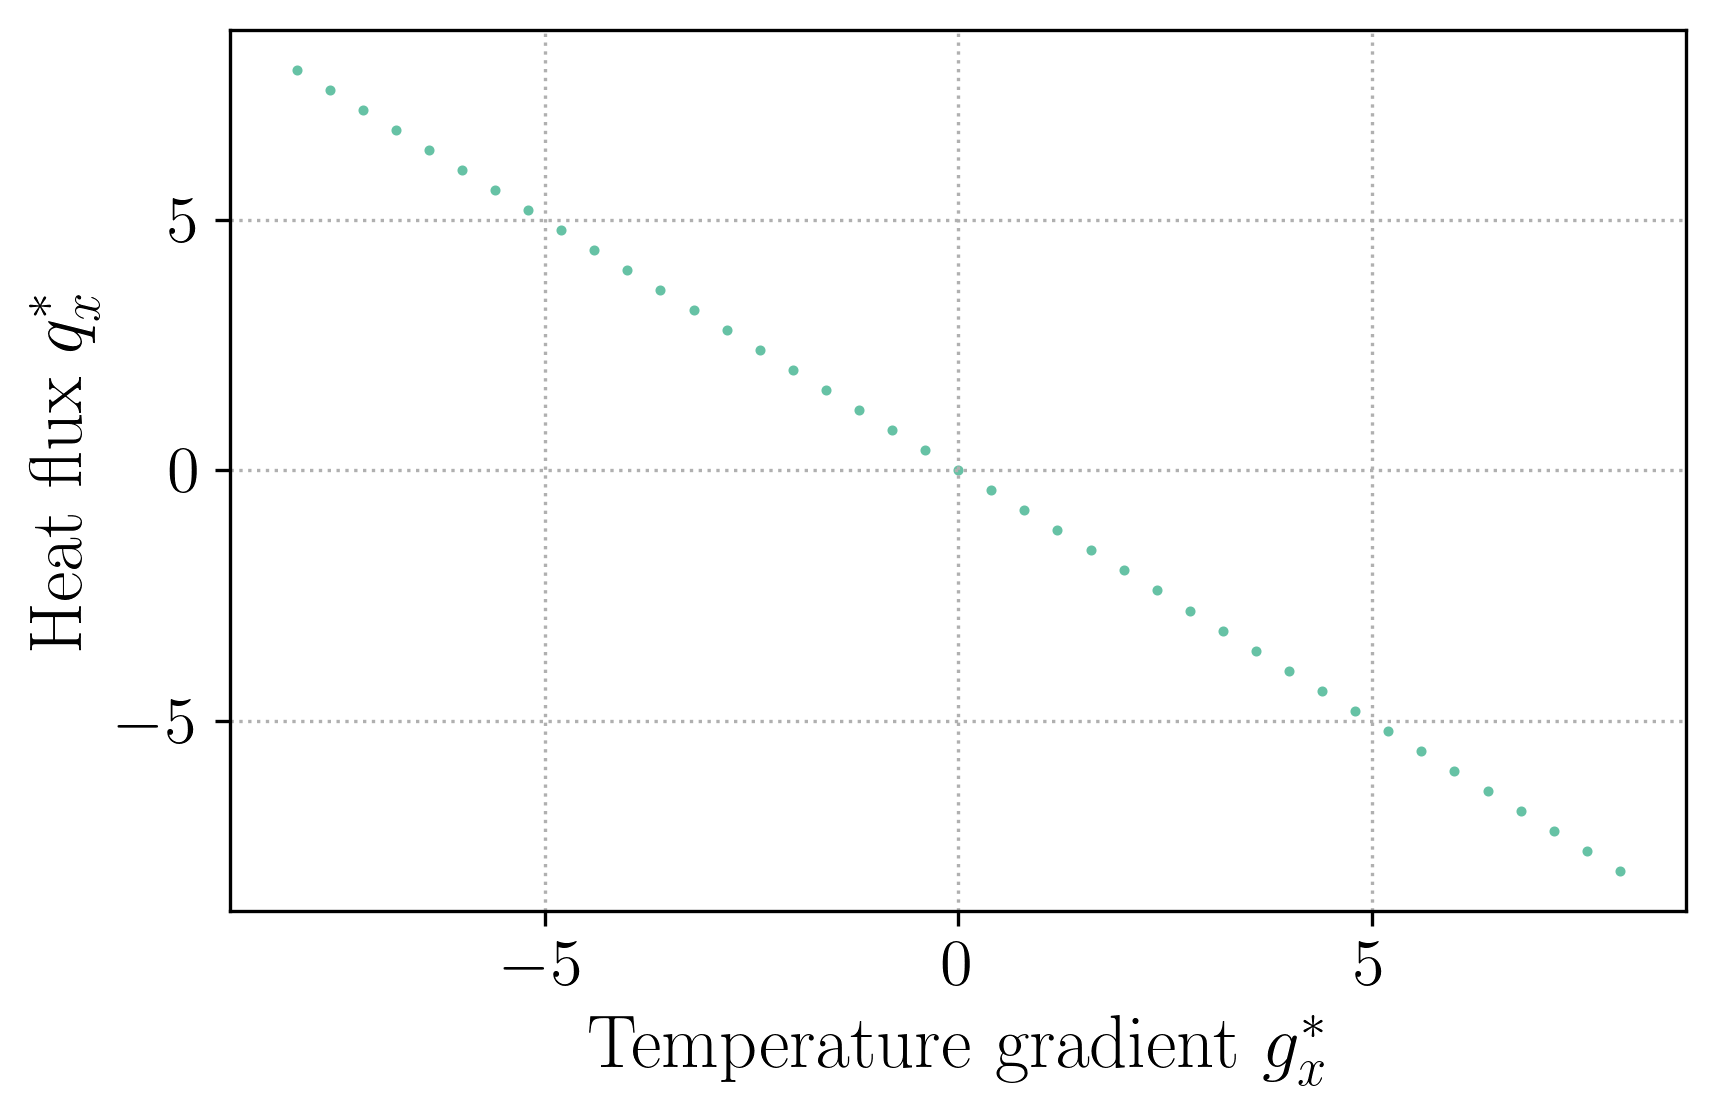

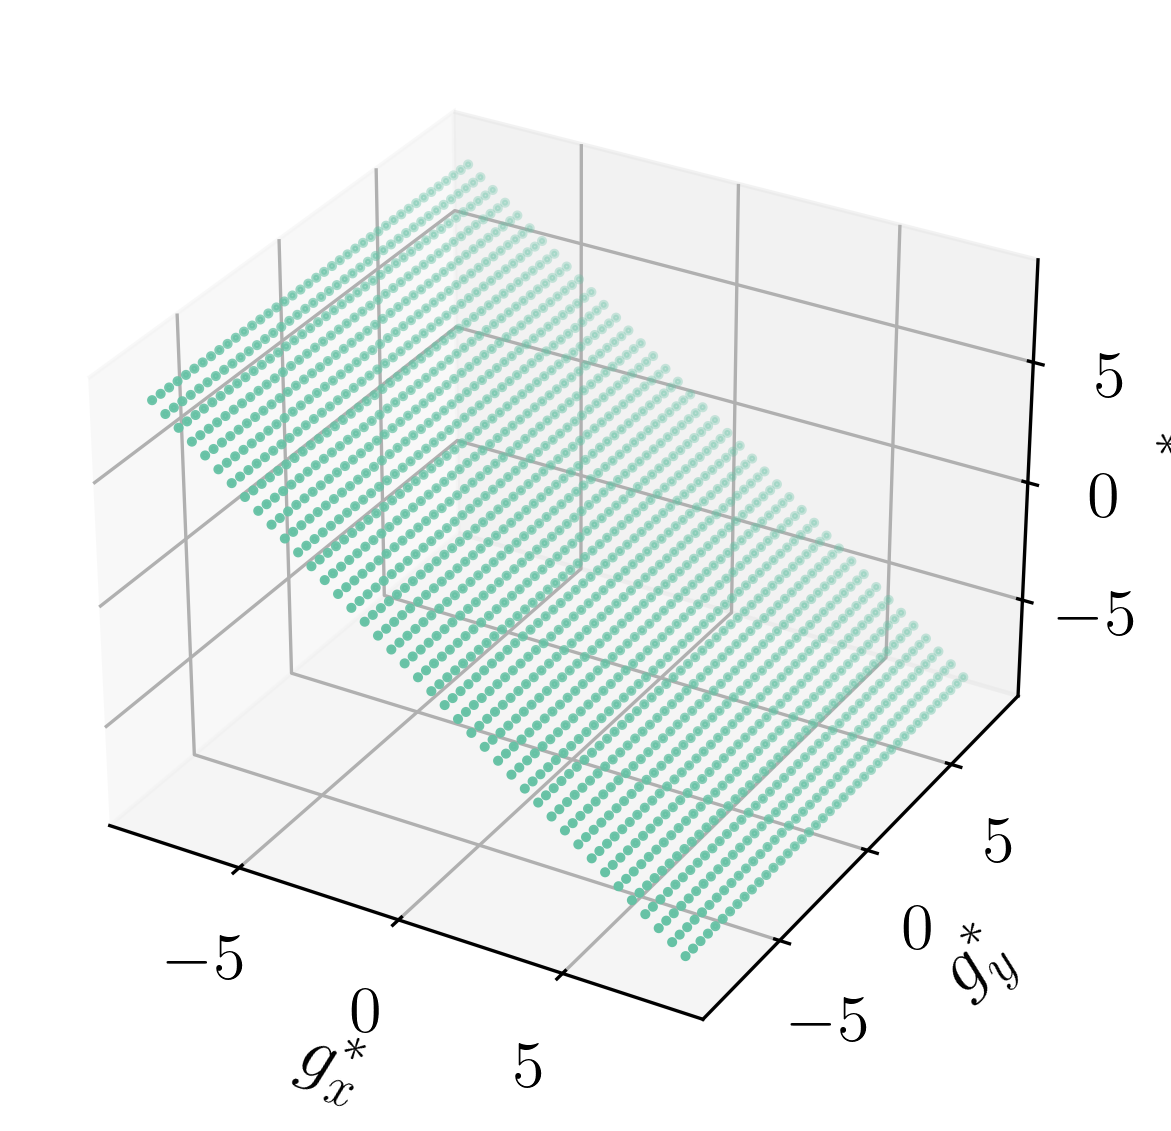

In [7]:
dataset_name = "grid_data.csv"
make_grid_linear_dataset(8, how_many, dataset_name, plot_dataset=True)

In [8]:
# Testing running analysis
!rm out_*

use_line = "-use_line"
use_line = ""

how_many = 41
make_grid_linear_dataset(8, how_many, dataset_name, plot_dataset=False)

params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"
!{mofem_part} -my_file {params.mesh_file + ".h5m"} -my_nparts {params.nproc} -output_file {params.part_file} -dim 2 -adj_dim 1
!{exe} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag} -csv_tree_file {dataset_name} -write_long_error_file {use_line} -print_integ

out_to_vtk = !ls -c1 out_result_*h5m

!convert.py {out_to_vtk[0]}

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id c8dfd486983b6cce1ab0f77eedb54e0da63082db
[0] <inform> Local time: 2024-5-20 15:39:57
[0] <inform> UTC time: 2024-5-20 15:39:57
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLUX_SQUARE_SINCOS             
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name PRESSURE_SQUARE_SINCOS         
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name SOURCE_SQUARE_SINCOS           
[0] <inform> [mofem_part] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [mofem_part] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLU

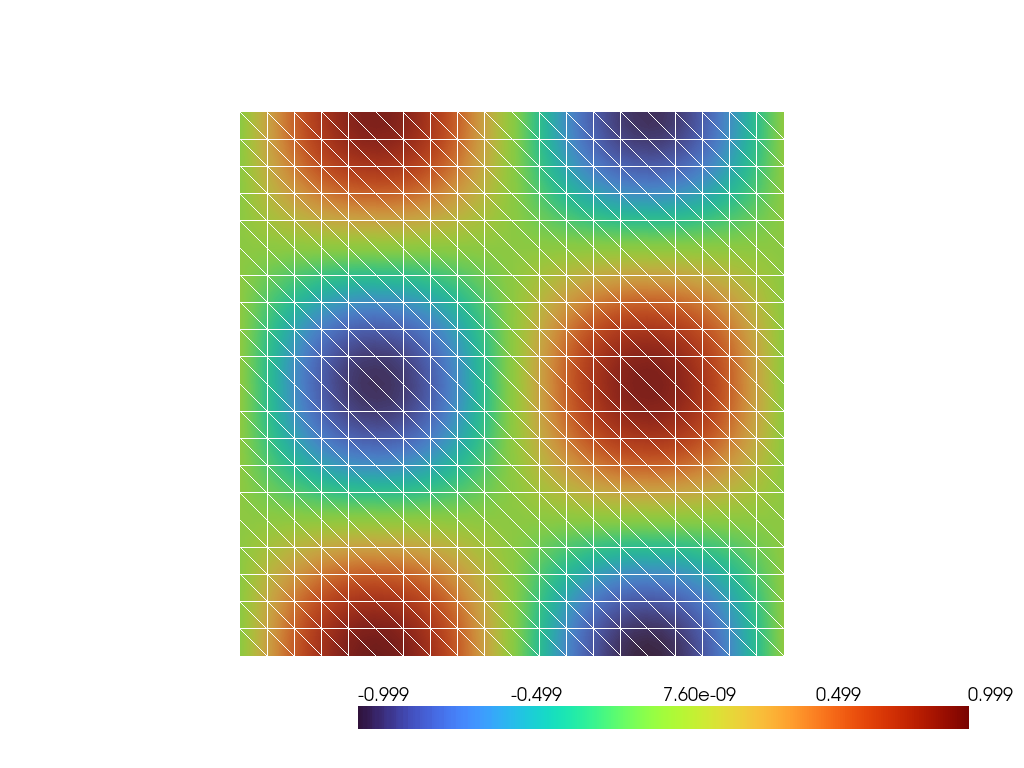

In [9]:

params.show_file = "out_iteration_"
params.show_file = "out_result_"
params.show_field = "T"
# params.warp_factor = 0.4  # warp factor
params.show_edges = True
# params.p_save = "run_test_p.pdf"
show_results(params)

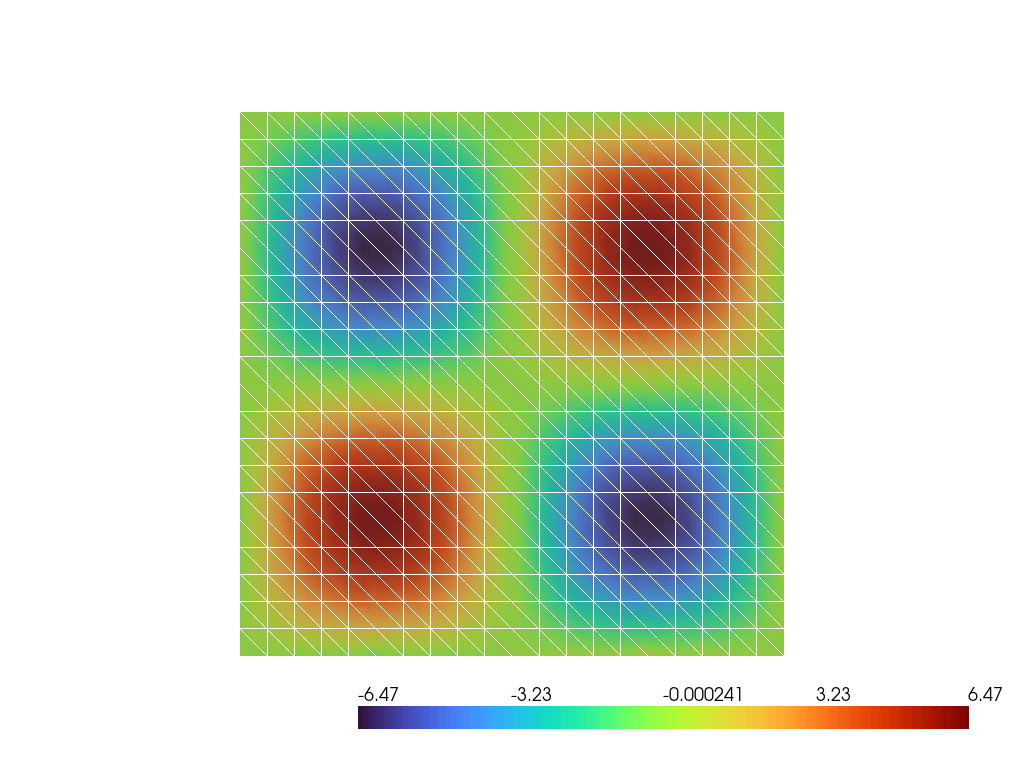

In [10]:
params.show_field = "Q"
params.field_part = 1
show_results(params)

Read "out_integ_pts_6.h5m"
Wrote "out_integ_pts_6.vtk"


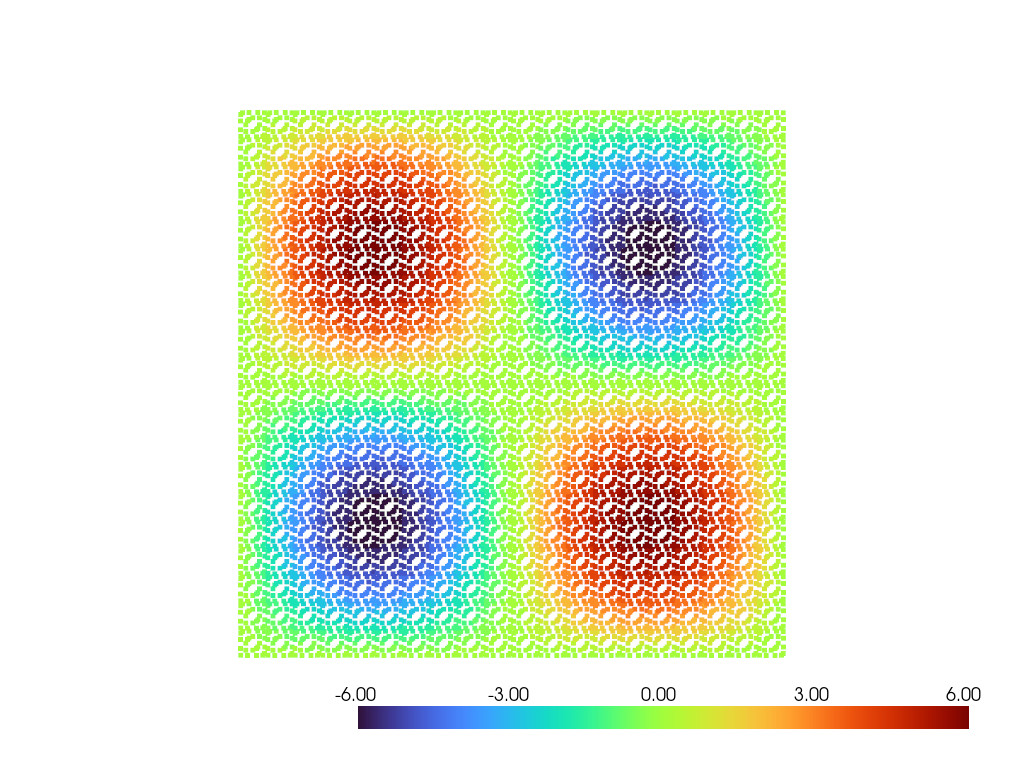

In [11]:
point_file = "out_integ_pts_6"

!mbconvert {point_file + ".h5m"} {point_file + ".vtk"}

params.show_file = "out_integ_pts_"
params.show_field = "GRAD(P)_STAR"
params.field_part = 1
# params.warp_factor = 0.4  # warp factor
params.show_edges = True
# params.p_save = "run_test_p.pdf"
show_resulting_points(params)

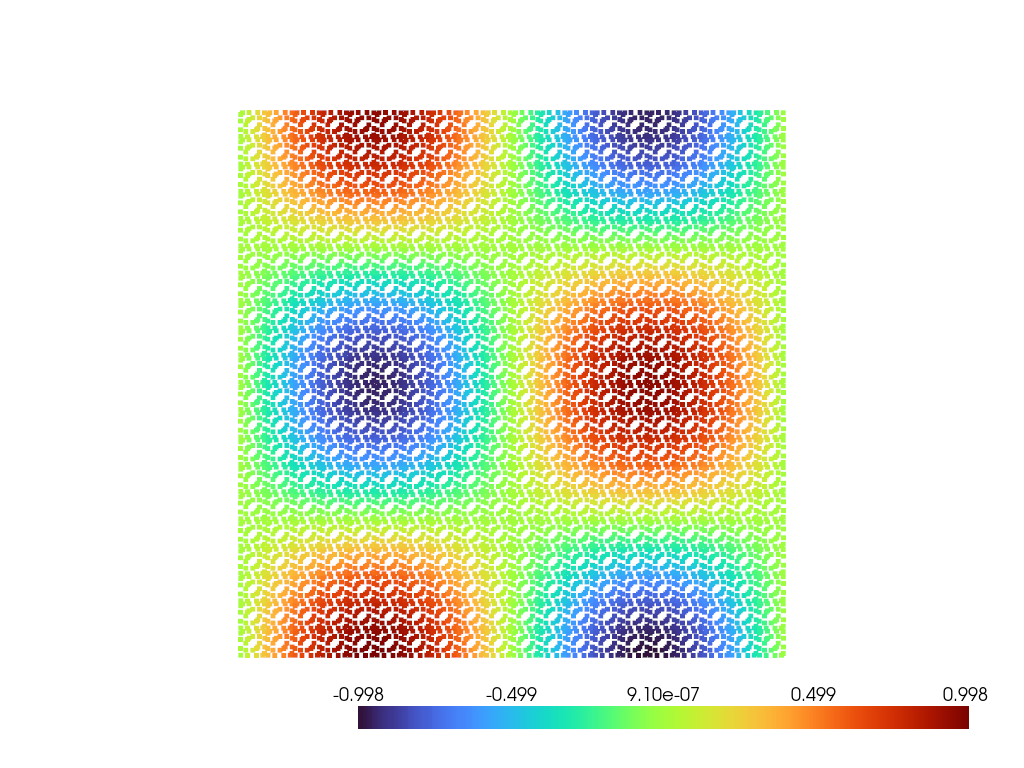

In [12]:
params.show_field = "T"
params.field_part = -1
# params.warp_factor = 0.4  # warp factor
# params.p_save = "run_test_p.pdf"
show_resulting_points(params)

In [13]:
def save_point_fields(vtk_file, point_index, csv_file):
    # Read the .vtk file
    mesh = pv.read(vtk_file)

    # Get the point
    point = mesh.points[point_index]

    # Get the fields (scalars) of the point
    fields = mesh.point_data

    # Prepare data for saving
    data_to_save = {field: fields[field][point_index] for field in fields}

    # Save the fields to a .csv file
    with open(csv_file, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=data_to_save.keys())
        writer.writeheader()

In [14]:
import csv
import glob
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv

!convert.py out_integ_pts_*

def get_point_fields(directory, point_index):
    # Get the list of .vtk files
    vtk_files = sorted(glob.glob(f"{directory}/out_integ_pts_*.vtk"))

    # Initialize a DataFrame to store the fields
    df = None

    for vtk_file in vtk_files:
        # Read the .vtk file
        mesh = pv.read(vtk_file)

        # Get the fields (scalars) of the point
        fields = mesh.point_data

        # Prepare data for saving
        data_to_save = {}
        for field in fields:
            if np.isscalar(fields[field][point_index]):
                # Scalar field
                data_to_save[field] = fields[field][point_index]
            elif len(fields[field][point_index].shape) == 1:
                # Vector field
                for i in range(fields[field][point_index].shape[0]):
                    data_to_save[f"{field}_{i}"] = fields[field][point_index][i]

        # Add the file number to the data
        file_number = int(vtk_file.split('_')[-1].split('.')[0])
        data_to_save['file_number'] = file_number

        # Append the data to the DataFrame
        if df is None:
            df = pd.DataFrame([data_to_save])
        else:
            df = pd.concat([df, pd.DataFrame([data_to_save])], ignore_index=True)

    return df

# plot_point_fields(".", 20)
df_gauss_vlaues = get_point_fields(".", 20)


 |██████████████████████████████████████████████████| 100.0% (9 of 9)



In [15]:
print(df_gauss_vlaues)

   GLOBAL_ID  GRAD(P)_0  GRAD(P)_1  GRAD(P)_2  GRAD(P)_STAR_0  GRAD(P)_STAR_1  \
0         -1   0.000000   0.000000        0.0             0.0             0.0   
1         -1   4.542974  -1.008066        0.0             2.8             0.0   
2         -1   5.148908  -0.668737        0.0             4.4            -0.4   
3         -1   5.668019  -0.655712        0.0             5.2            -0.4   
4         -1   5.813457  -0.608115        0.0             5.6            -0.4   
5         -1   5.891702  -0.558974        0.0             5.6            -0.4   
6         -1   5.755165  -0.566038        0.0             5.6            -0.4   
7         -1   5.789156  -0.552558        0.0             5.6            -0.4   
8         -1   5.789622  -0.550488        0.0             5.6            -0.4   
9         -1   5.789622  -0.550488        0.0             5.6            -0.4   

   GRAD(P)_STAR_2  NORMAL_0  NORMAL_1  NORMAL_2  ...  P_difference  \
0             0.0       0.0       0.0 

In [16]:
dataset_name = "grid_data.csv"
grid_data = pd.read_csv(dataset_name)

/mofem_install/jupyter/adriana/.local/lib/python3.11/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/mofem_install/jupyter/adriana/.local/lib/python3.11/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


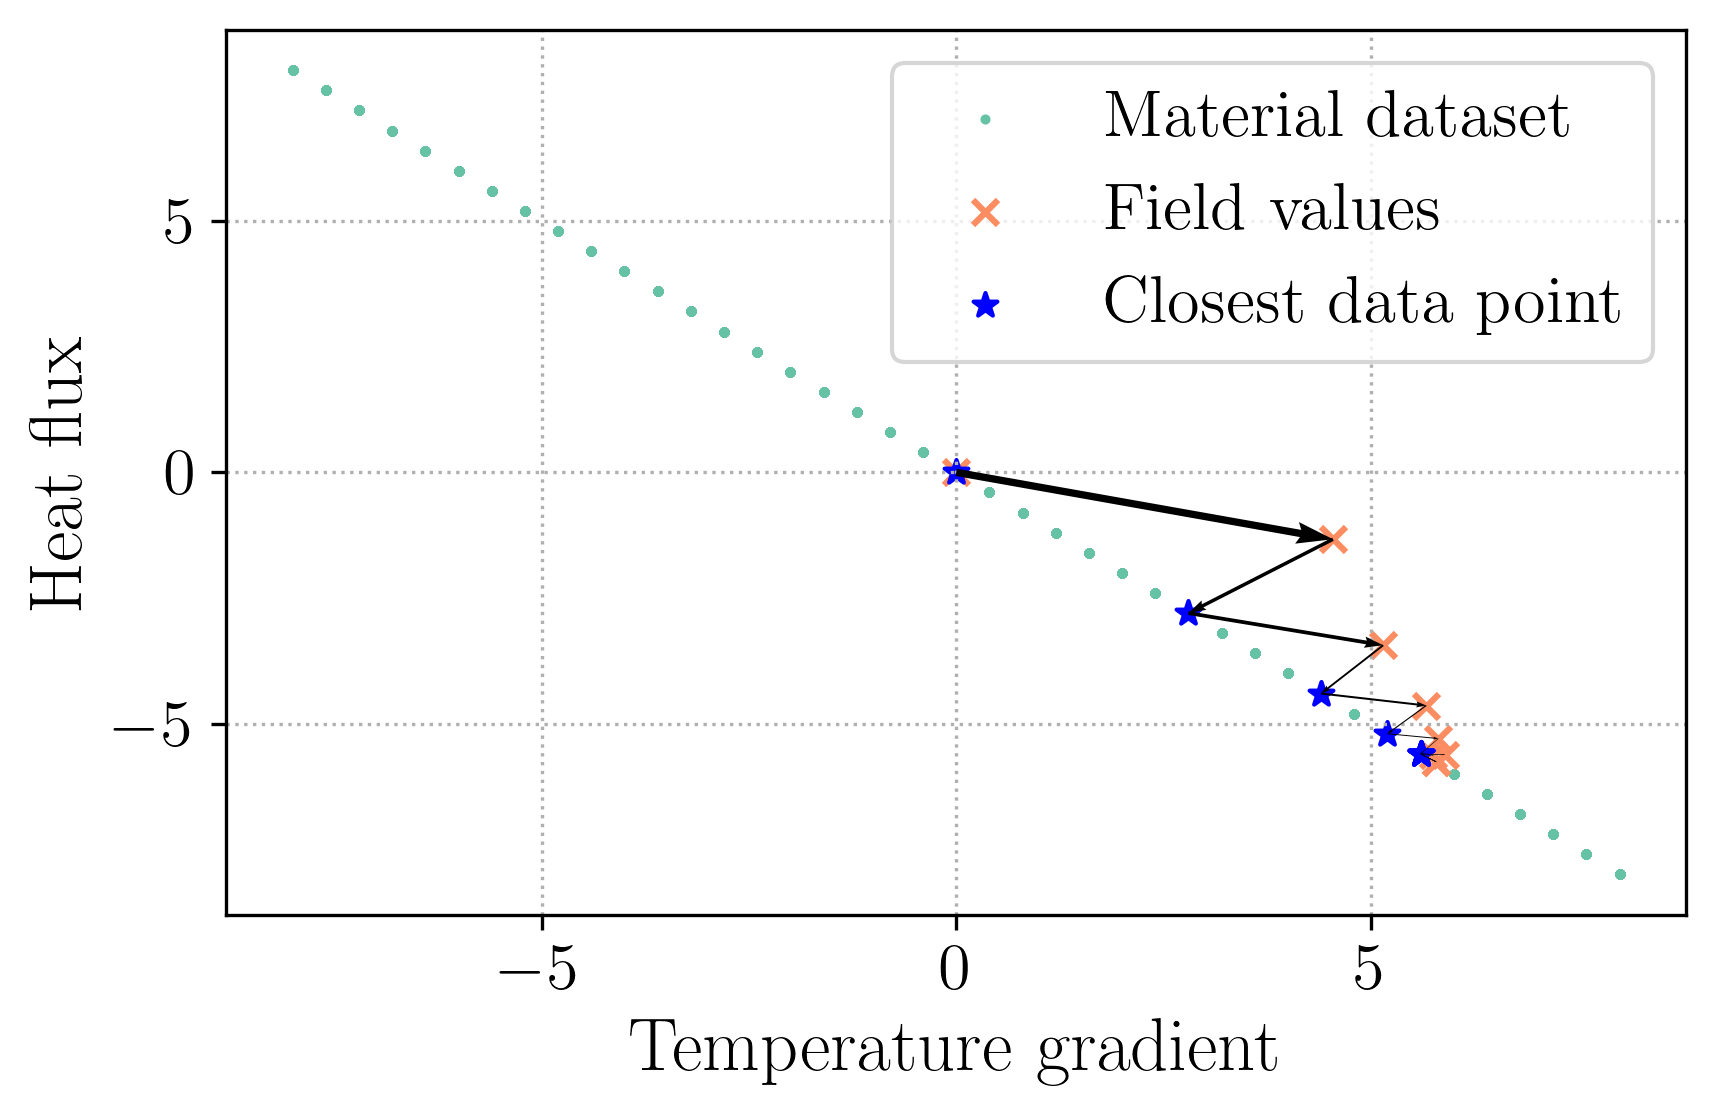

In [17]:
# Interleave the points from 'fields' and 'stars'
x_values = np.ravel(np.column_stack((df_gauss_vlaues['GRAD(P)_0'], df_gauss_vlaues['GRAD(P)_STAR_0'])))
y_values = np.ravel(np.column_stack((df_gauss_vlaues['Q_0'], df_gauss_vlaues['Q_STAR_0'])))


# Calculate the differences between consecutive points
dx = np.diff(x_values)
dy = np.diff(y_values)

# Calculate the length of each line segment
lengths = np.hypot(dx, dy)

plt.figure()
plt.scatter(grid_data['gradx'], grid_data['fluxx'], label='Material dataset', zorder=1, s=2)
plt.scatter(df_gauss_vlaues['GRAD(P)_0'], df_gauss_vlaues['Q_0'], label='Field values', marker='x', zorder=1)
plt.scatter(df_gauss_vlaues['GRAD(P)_STAR_0'], df_gauss_vlaues['Q_STAR_0'], label='Closest data point', marker='*', zorder=1, color='b')

# Normalize the lengths to get widths
widths = lengths / np.max(lengths) * 0.005  # adjust the factor as needed

# Plot each arrow individually with its own width
for i in range(len(x_values[:-1])):
    plt.quiver(x_values[i], y_values[i], dx[i], dy[i], scale_units='xy', angles='xy', scale=1, color='black', width=widths[i], zorder=2)

# plt.xlabel('Greadient')
# plt.ylabel('Flux')
plt.xlabel(r'Temperature gradient')
plt.ylabel(r'Heat flux')
# plt.xlim(-0.5,8)
# plt.ylim(-8,0.5)
ax = plt.gca()  # Define ax variable
ax.grid(True, ls=':')  # Call ax.grid() method
plt.legend()
plt.tight_layout()
plt.savefig('integration_journey.pdf')
plt.show()


In [18]:
data = pd.read_csv('errors_long_file.csv', header=0,  index_col=False)

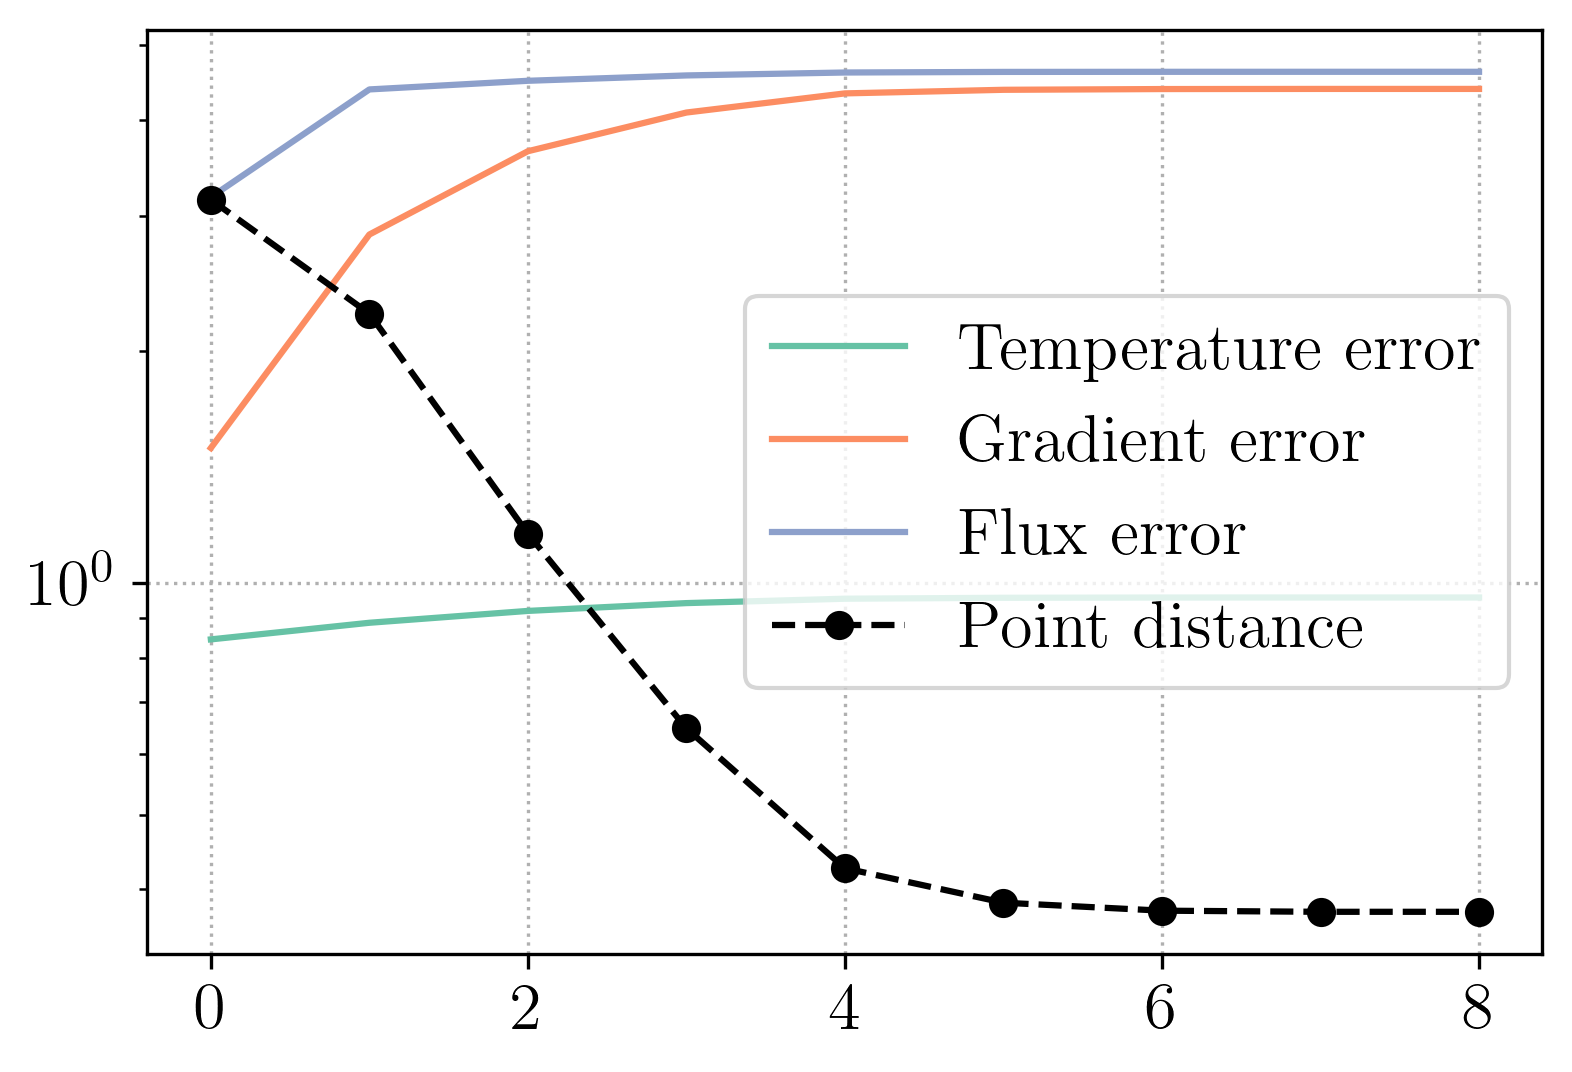

In [19]:
fig, ax = plt.subplots()
ax.plot(data['rmsErr_long_file'], label=r'Temperature error')
ax.plot(data[' rmsGradErr_long_file'], label=r'Gradient error')
ax.plot(data[' rmsFluxErr_long_file'], label=r'Flux error')
ax.plot(data[' rmsPointDistErr_long_file'], label=r'Point distance', ls='--', color='black', marker='o')
ax.set_yscale('log')
ax.grid(True, ls=':')
ax.legend()

## Plot with line and with dataset

In [20]:
main_error_file = "errors_long_file.csv"

line_errors = "line_errors.csv"
data_errors = "data_errors.csv"

use_line = "-use_line"
use_line = ""

how_many = 101
make_grid_linear_dataset(8, how_many, dataset_name, plot_dataset=False)

params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"
!{mofem_part} -my_file {params.mesh_file + ".h5m"} -my_nparts {params.nproc} -output_file {params.part_file} -dim 2 -adj_dim 1
# # !{classic_diffusion} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag}
# !{data_driven_diffusion_snes} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag} -csv_tree_file {dataset_name} -write_long_error_file {use_line}

# !mv {main_error_file} {data_errors}


# Create an empty DataFrame to store the data
all_data = []

# Define the range of values for how_many
# how_many_values = [11, 101, 1001, 10001]
how_many_values = [11, 101, 1001]

for how_many in how_many_values:
    !rm {main_error_file}

    make_grid_linear_dataset(8, how_many, dataset_name, plot_dataset=False)

    !{data_driven_diffusion_snes} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag} -csv_tree_file {dataset_name} -write_long_error_file {use_line}
    
    # Read the data from the main_error_file
    data = pd.read_csv(main_error_file)
    
    # Append the data to the all_data DataFrame
    all_data.append(data)

# # Save the combined data to a CSV file
# all_data.to_csv("combined_data.csv", index=False)

# print(all_data)

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id c8dfd486983b6cce1ab0f77eedb54e0da63082db
[0] <inform> Local time: 2024-5-20 15:40:34
[0] <inform> UTC time: 2024-5-20 15:40:34
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLUX_SQUARE_SINCOS             
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name PRESSURE_SQUARE_SINCOS         
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name SOURCE_SQUARE_SINCOS           
[0] <inform> [mofem_part] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [mofem_part] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLU

In [21]:

# print(all_data)

In [22]:
use_line = "-use_line"

# params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"
# !{mofem_part} -my_file {params.mesh_file + ".h5m"} -my_nparts {params.nproc} -output_file {params.part_file} -dim 2 -adj_dim 1
# !{classic_diffusion} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag}
!{exe} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag} -csv_tree_file {dataset_name} -write_long_error_file {use_line}

!mv {main_error_file} {line_errors}

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id c8dfd486983b6cce1ab0f77eedb54e0da63082db
[0] <inform> Local time: 2024-5-20 15:40:54
[0] <inform> UTC time: 2024-5-20 15:40:54
[0] <inform> [DD] -my_order 2
[0] <inform> [DD] -my_dummy_k 1
[0] <inform> [DD] -csv_tree_file grid_data.csv
[0] <inform> [DD] -data_dim 4
[0] <inform> [DD] -skip_vtk 0
[0] <inform> [DD] -write_long_error_file used .: convergence of errors through iterations is saved in .csv file
[0] <inform> [DD] -print_moab 0
[0] <inform> [DD] -point_dist_tol 1e-10
[0] <inform> [DD] -scaling used
[0] <inform> [DD] -use_line used (instead of dataset equation line will determine * values)
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLUX_SQUARE_SINCOS             
[0] <inform

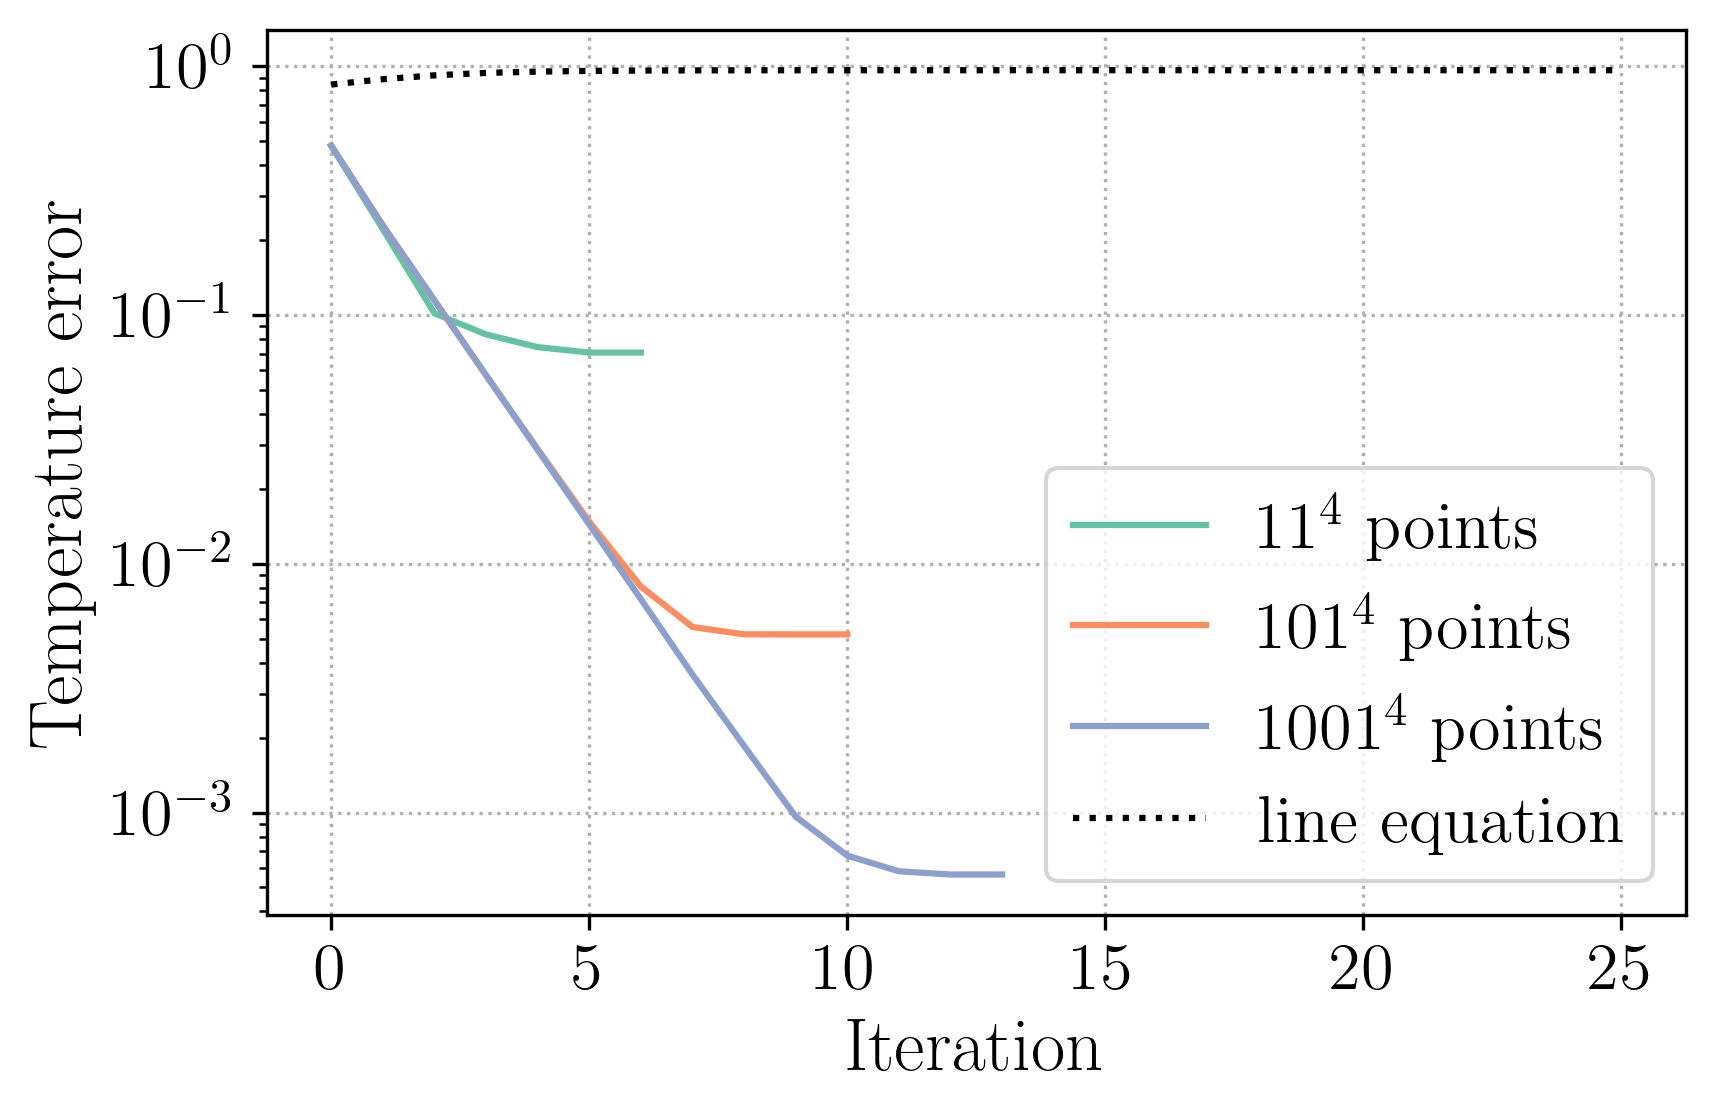

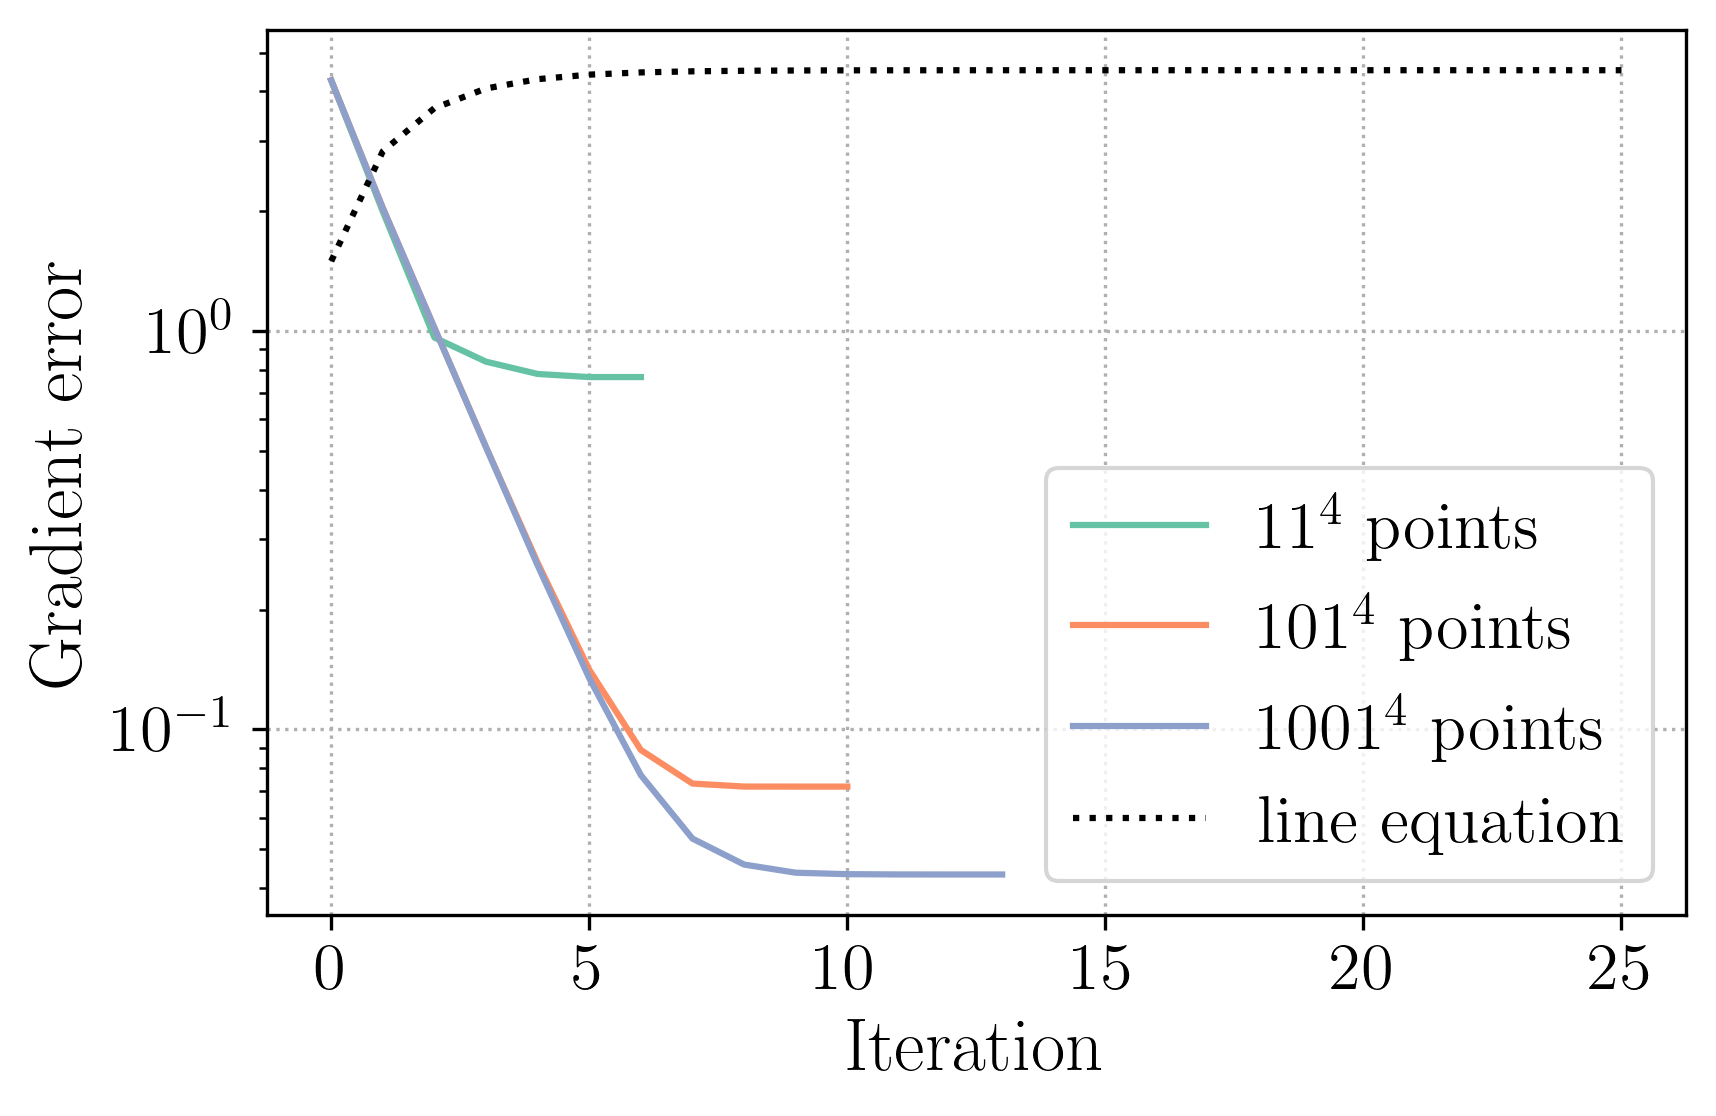

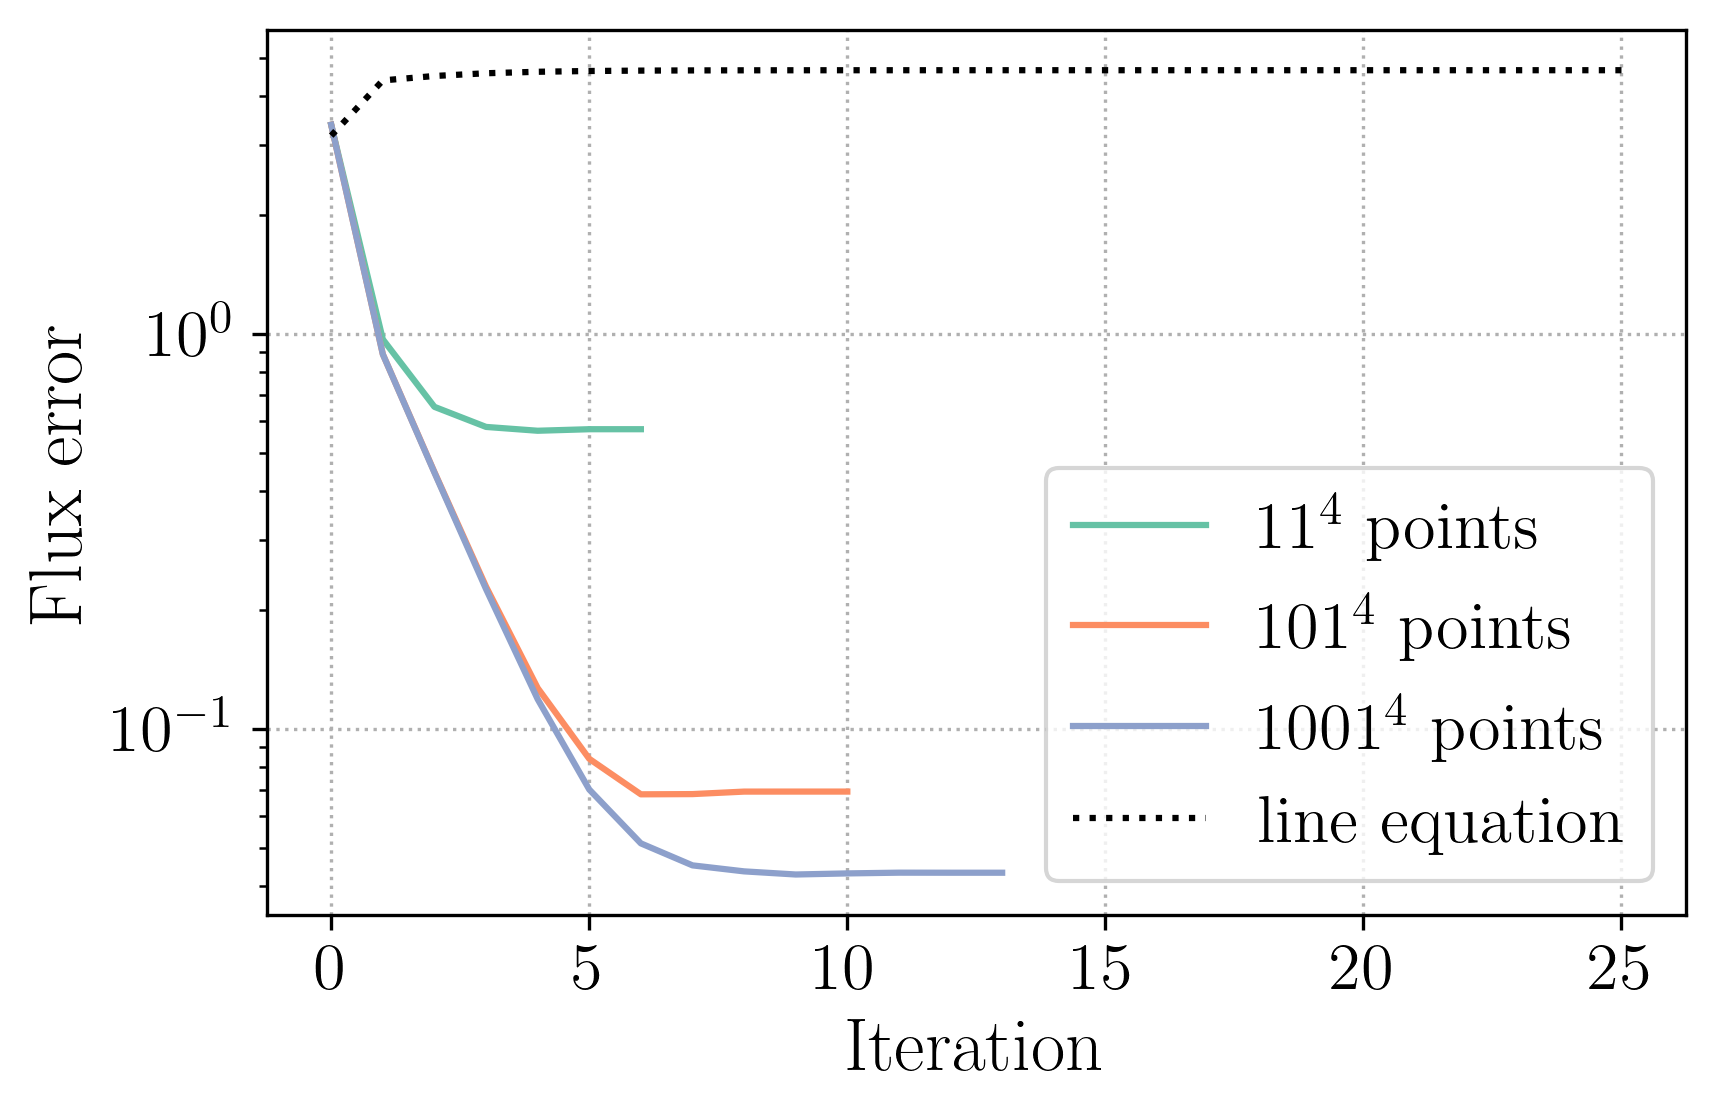

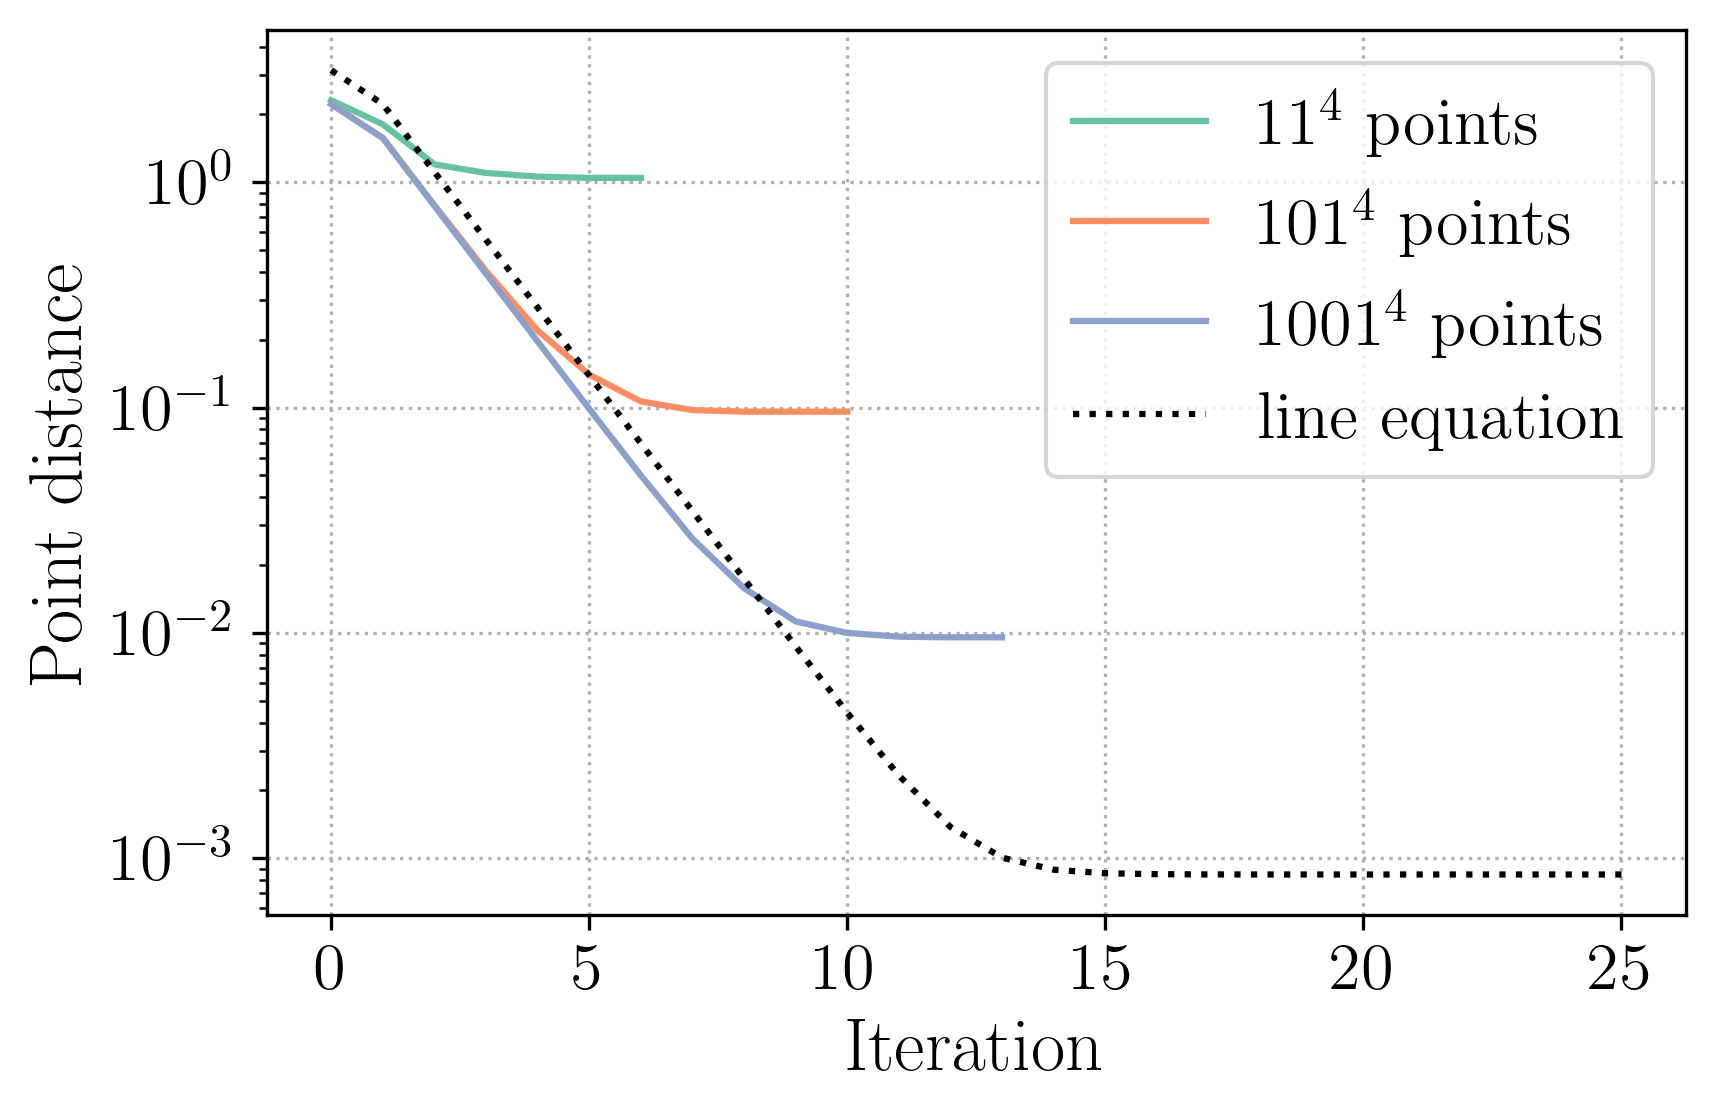

In [23]:
line_pd = pd.read_csv(line_errors, header=0,  index_col=False)

error = 'rmsErr_long_file'
label = r'Temperature error'

def plot_error(error, label):

    fig, ax = plt.subplots()

    for i in range(len(all_data)):
        ax.plot(all_data[i][error], label=f"{how_many_values[i]}$^4$ points")

    ax.plot(line_pd[error], label=r'line equation', ls=':', color='black')
    ax.set_ylabel(label)
    ax.set_xlabel(r'Iteration')
    ax.set_yscale('log')
    ax.grid(True, ls=':')
    ax.legend()
    plt.tight_layout()
    plt.savefig('DD_iteration_'+error+'.pdf')

plot_error('rmsErr_long_file', r'Temperature error')
plot_error(' rmsGradErr_long_file', r'Gradient error')
plot_error(' rmsFluxErr_long_file', r'Flux error')
plot_error(' rmsPointDistErr_long_file', r'Point distance')

In [24]:
# line_pd = pd.read_csv(line_errors, header=0,  index_col=False)
# data_pd = pd.read_csv(data_errors, header=0,  index_col=False)

# fig, ax = plt.subplots()
# ax.plot(data_pd['rmsErr_long_file'], label=r'Temperature error')
# ax.plot(data_pd[' rmsGradErr_long_file'], label=r'Gradient error')
# ax.plot(data_pd[' rmsFluxErr_long_file'], label=r'Flux error')
# ax.plot(data_pd[' rmsPointDistErr_long_file'], label=r'Point distance', ls='--', color='black', marker='o')
# ax.set_ylabel(r'Global RMS error')
# ax.set_xlabel(r'Iteration')
# ax.set_yscale('log')
# ax.grid(True, ls=':')
# y_range = ax.get_ylim()
# ax.legend()
# plt.tight_layout()
# fig.savefig("DD_small_data_errors_with_iterations.pdf")

# fig, ax = plt.subplots()
# ax.plot(line_pd['rmsErr_long_file'], label=r'Temperature error')
# ax.plot(line_pd[' rmsGradErr_long_file'], label=r'Gradient error')
# ax.plot(line_pd[' rmsFluxErr_long_file'], label=r'Flux error')
# ax.plot(line_pd[' rmsPointDistErr_long_file'], label=r'Point distance', ls='--', color='black', marker='o')
# ax.set_ylabel(r'Global RMS error')
# ax.set_xlabel(r'Iteration')
# ax.set_yscale('log')
# ax.grid(True, ls=':')
# ax.legend()
# ax.set_ylim(y_range)
# plt.tight_layout()
# fig.savefig("DD_line_errors_with_iterations.pdf")
